# IDRIS

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Lets create a sinwave

In [2]:
x = torch.linspace(0,799,800) #---> Created 800 digits linearly spaced
y = torch.sin(x*2*3.14/40) #----> The values were linear so this of code will covert them to sinwave

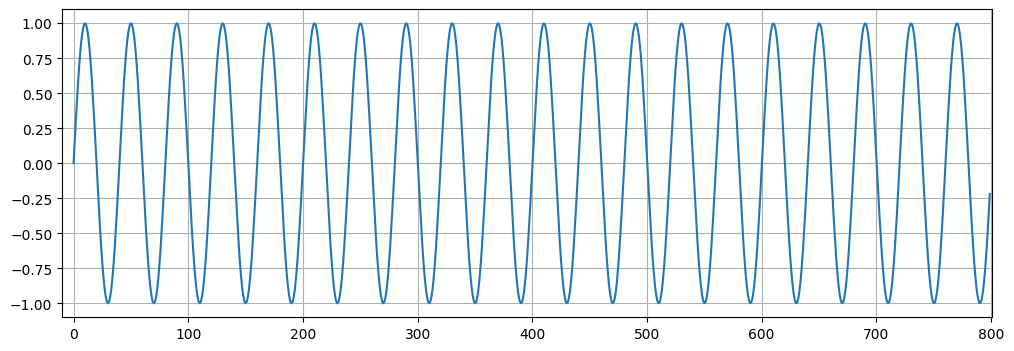

In [3]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

# Let's create a train and test set.
we will not be doing train and test split randomly we will split them in sequence.

In [4]:
test_size = 40
train_set = y[:-test_size] # ----> 760 for training set
test_set = y[-test_size:] # ----> 40 for test set

Let's plot our train_set

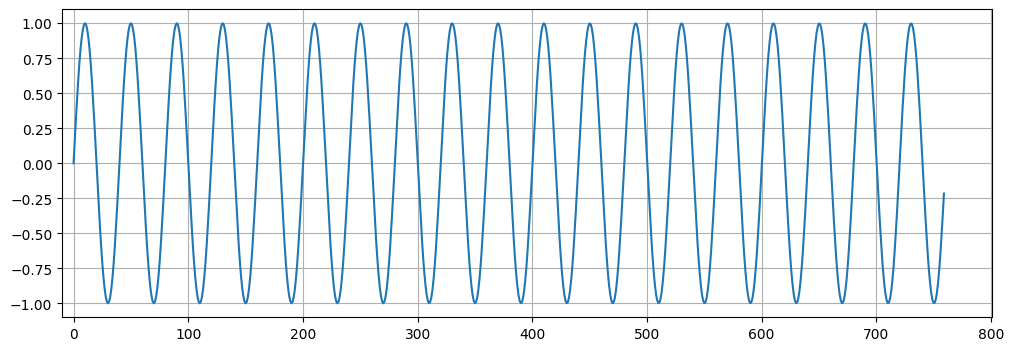

In [5]:
plt.figure(figsize = (12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set)

## Prepare the training data
When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows". Each window consists of a connected string of samples. The label used for comparison is equal to the next value in the sequence. In this way our network learns what value should follow a given pattern of preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only care about the last one.

In [6]:
def input_data(seq,ws):  # ws is the window size
    out = []    # ----> ([0,1,2,3],[4])   ([1,2,3,4],[5]) and so on
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [7]:

# This just an example for the above function
#This is code just for better understanding of the above code

#Line 1
#     def input_data(seq, ws):

#Line 2
#    out = []    # out is initialized as an empty list

# Line 3
#    L = len(seq)  # L is set to the length of the input sequence, L = 6

# Line 4
#    for i in range(L - ws):  # Iterating over the range (0, 6 - 4) => (0, 2)

# Iteration 1:
        # Line 5
#       window = seq[0:4]  # window = [0, 1, 2, 3]

        # Line 6
#        label = seq[4:5]   # label = [4]

        # Line 7
#       out.append((window, label))  # out = [([0, 1, 2, 3], [4])]

# Iteration 2:
        # Line 5
#        window = seq[1:5]  # window = [1, 2, 3, 4]

        # Line 6
#       label = seq[5:6]   # label = [5]

        # Line 7
#        out.append((window, label))  # out = [([0, 1, 2, 3], [4]), ([1, 2, 3, 4], [5])]

# Line 8
#    return out  # Returns the final list of tuples

# Example Call
#result = input_data([0, 1, 2, 3, 4, 5], 4)
#print(result) ###

In [8]:
window_size = 40

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_set,window_size)

len(train_data) # this should equal 760-40

720

In [9]:

train_data[0]

(tensor([ 0.0000,  0.1564,  0.3089,  0.4538,  0.5875,  0.7068,  0.8087,  0.8908,
          0.9509,  0.9876,  1.0000,  0.9878,  0.9514,  0.8915,  0.8097,  0.7080,
          0.5888,  0.4552,  0.3104,  0.1579,  0.0016, -0.1548, -0.3074, -0.4524,
         -0.5862, -0.7057, -0.8078, -0.8900, -0.9504, -0.9873, -1.0000, -0.9881,
         -0.9518, -0.8922, -0.8106, -0.7091, -0.5901, -0.4566, -0.3119, -0.1595]),
 tensor([-0.0032]))

# Defining Class for our LSTM model

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),  # initializing zero the hidden state
                       torch.zeros(1,1,hidden_size))  # ---> initializing zero the cell state

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

Initializing with zeros helps break symmetry in the learning process. If all hidden and cell states started with the same initial values, the model might face difficulties in learning diverse representations and capturing different patterns. Zeros provide a symmetrically neutral starting point.

In [11]:
model = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Trainig and simultaneously evaluating

 The initial setting of hidden and cell states to zeros in the model definition provides a default starting point for the model. This allows for immediate use of the model for prediction or inference without explicit initialization. During training, the states are reset to zeros before processing each sequence to ensure a consistent starting point for learning from the training data.

Epoch:  1 Loss: 0.00011323
Loss on test predictions: 0.002161120530217886


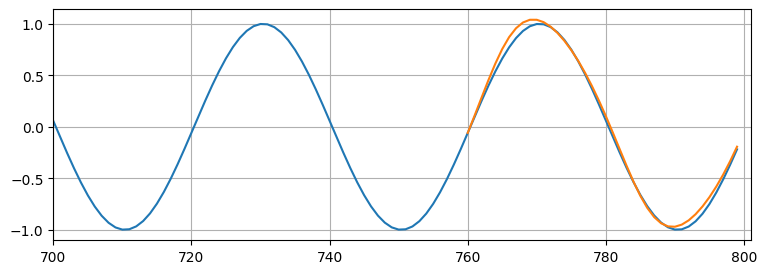

Epoch:  2 Loss: 0.00010653
Loss on test predictions: 0.002110614674165845


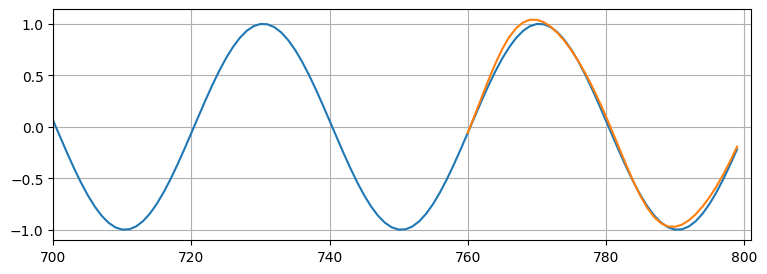

Epoch:  3 Loss: 0.00010066
Loss on test predictions: 0.0020651479717344046


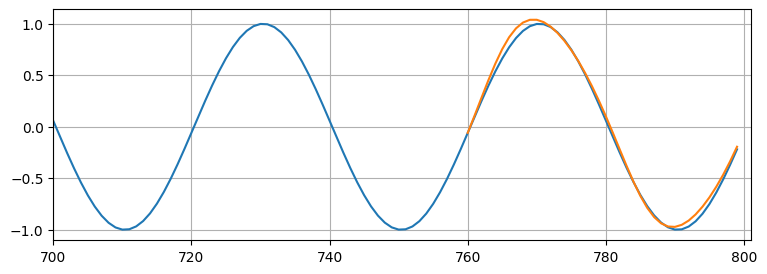

Epoch:  4 Loss: 0.00009547
Loss on test predictions: 0.00202372157946229


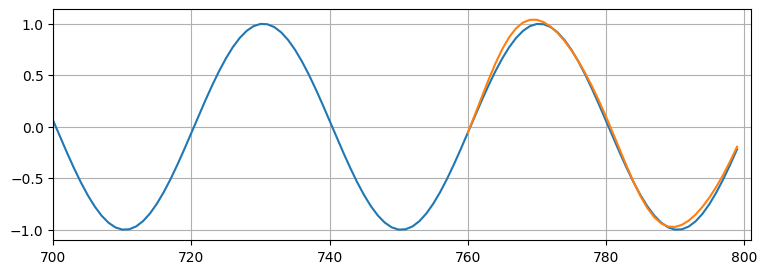

Epoch:  5 Loss: 0.00009086
Loss on test predictions: 0.001985511276870966


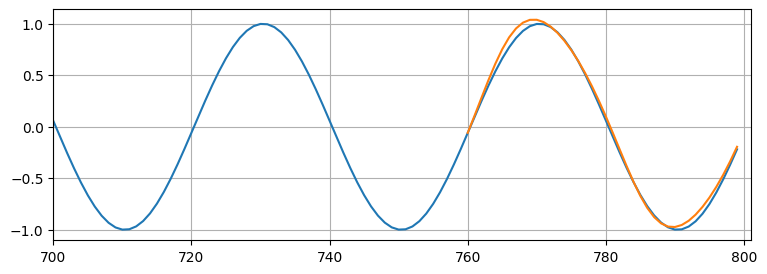

Epoch:  6 Loss: 0.00008672
Loss on test predictions: 0.0019499778281897306


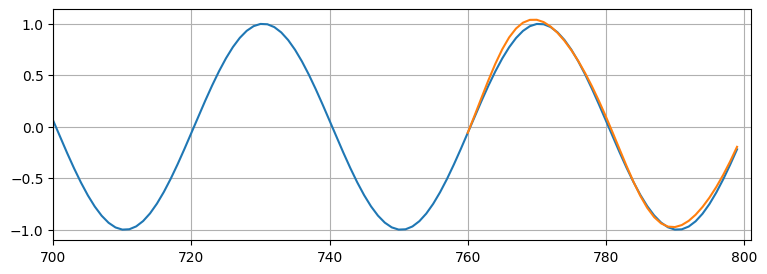

Epoch:  7 Loss: 0.00008298
Loss on test predictions: 0.001916644163429737


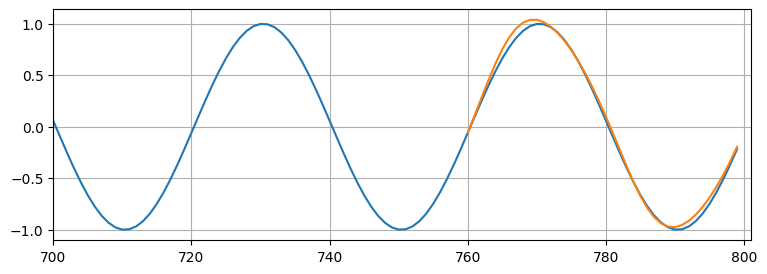

Epoch:  8 Loss: 0.00007958
Loss on test predictions: 0.0018851564964279532


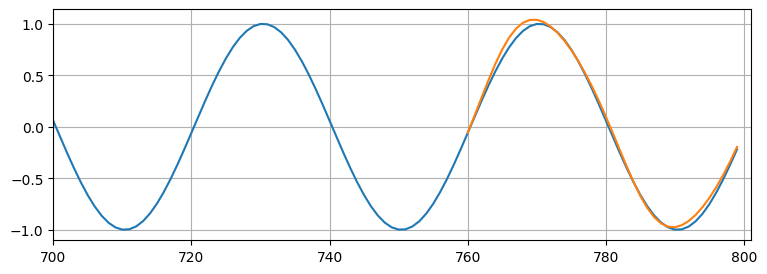

Epoch:  9 Loss: 0.00007647
Loss on test predictions: 0.0018552523106336594


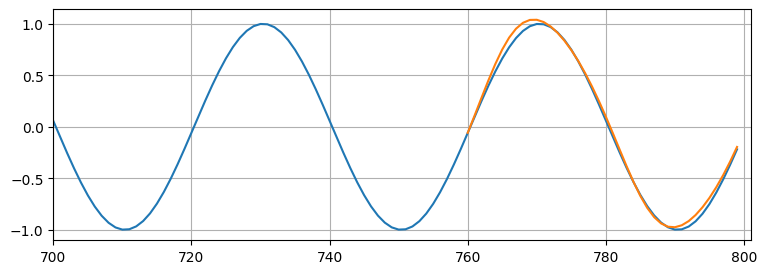

Epoch: 10 Loss: 0.00007362
Loss on test predictions: 0.0018267022678628564


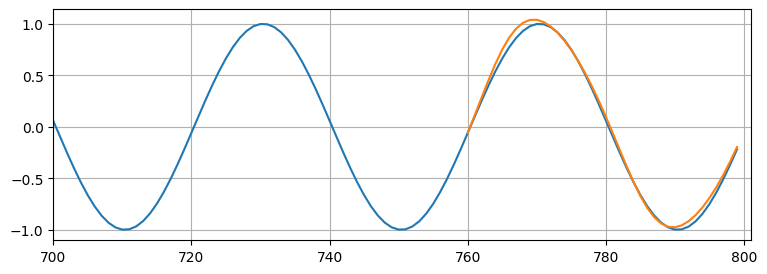


Duration: 13 seconds


In [15]:
import time
start_time = time.time()
epochs = 10
future = 40

for i in range(epochs):

    # tuple-unpack the train_data set
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

    # MAKE PREDICTIONS
    # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())

    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(9,3))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

# Forecasting into an unknown future

In [13]:
epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)  # this should equal 800-40

import time
start_time = time.time()

for i in range(epochs):

    # tuple-unpack the entire set of data
    for seq, y_train in all_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)

        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Epoch:  1 Loss: 0.00035279
Epoch:  2 Loss: 0.00029876
Epoch:  3 Loss: 0.00025718
Epoch:  4 Loss: 0.00022470
Epoch:  5 Loss: 0.00019894
Epoch:  6 Loss: 0.00017825
Epoch:  7 Loss: 0.00016138
Epoch:  8 Loss: 0.00014749
Epoch:  9 Loss: 0.00013588
Epoch: 10 Loss: 0.00012609

Duration: 11 seconds


## Predict future values, plot the result

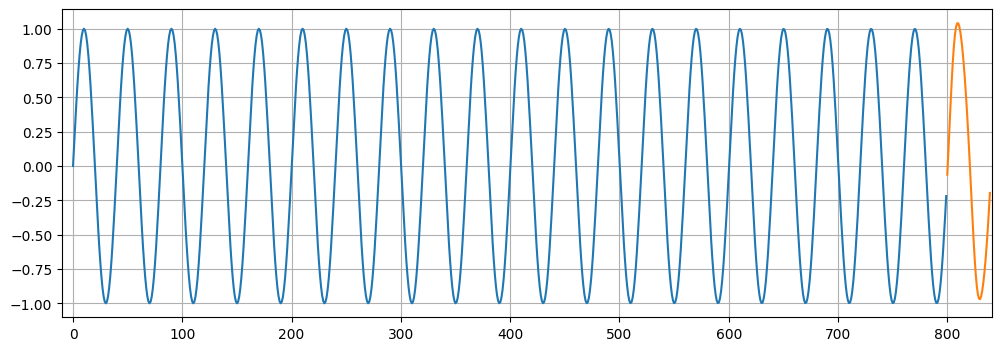

In [14]:
preds = y[-window_size:].tolist()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()


# Thank YOU